# Data Preprocessing for Bird Sound Neural Network Project

This notebook prepares the bird sound spectrogram data for neural network modeling.

We will:
- Load the HDF5 spectrogram dataset
- Explore and visualize the data
- Normalize spectrograms
- Pad/trim all spectrograms to a fixed shape
- Encode species labels
- Split the data into training, validation, and test sets
- (Optional) Save the preprocessed data for modeling


In [9]:
# 1. Load and Inspect Data

import h5py
import numpy as np
import matplotlib.pyplot as plt

h5_path = '../data/bird_spectrograms.hdf5'
target_shape = (343, 256)  # (time, frequency)

def pad_or_trim(spec, target_shape=(343, 256)):
    t, f = spec.shape
    target_t, target_f = target_shape
    # Trim if too large
    spec = spec[:target_t, :target_f]
    # Pad if too small
    pad_t = max(0, target_t - spec.shape[0])
    pad_f = max(0, target_f - spec.shape[1])
    if pad_t > 0 or pad_f > 0:
        spec = np.pad(spec, ((0, pad_t), (0, pad_f)), mode='constant')
    return spec

with h5py.File(h5_path, 'r') as f:
    species_names = list(f.keys())
    print("Species in dataset:", species_names)
    X = []
    y = []
    for sp in species_names:
        data = np.array(f[sp])  # shape: (n_samples, ?, ?)
        # Apply padding/trimming to each spectrogram
        data_fixed = np.array([pad_or_trim(spec, target_shape) for spec in data])
        X.append(data_fixed)
        y.extend([sp] * data_fixed.shape[0])
    X = np.concatenate(X, axis=0)
    y = np.array(y)
print(f"Total samples: {X.shape[0]}")
print(f"Spectrogram shape (time, freq): {X.shape[1:]}")


Species in dataset: ['amecro', 'amerob', 'bewwre', 'bkcchi', 'daejun', 'houfin', 'houspa', 'norfli', 'rewbla', 'sonspa', 'spotow', 'whcspa']
Total samples: 1536
Spectrogram shape (time, freq): (343, 256)


## 2. Explore and Visualize the Data

Let's look at the number of samples per species and display a few spectrograms.


Samples per species:
amecro: 128
amerob: 128
bewwre: 128
bkcchi: 128
daejun: 128
houfin: 128
houspa: 128
norfli: 128
rewbla: 128
sonspa: 128
spotow: 128
whcspa: 128


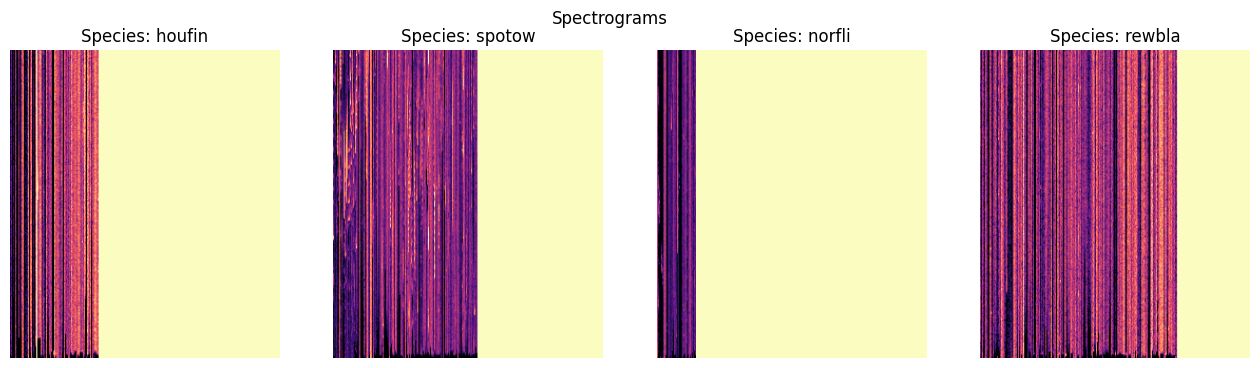

In [16]:
import collections

# Count samples per species
counter = collections.Counter(y)
print("Samples per species:")
for sp, count in counter.items():
    print(f"{sp}: {count}")

# Visualize a few random spectrograms
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, ax in enumerate(axes):
    idx = np.random.randint(0, len(X))
    ax.imshow(X[idx], aspect='auto', origin='lower', cmap='magma')
    ax.set_title(f"Species: {y[idx]}")
    ax.axis('off')
plt.suptitle("Spectrograms")
plt.savefig('../results/figures/Spectograms')
plt.show()


## 3. Normalize Spectrograms

We scale the spectrogram values to [0, 1] for stable neural network training.


In [11]:
# Min-max normalization
X_min, X_max = X.min(), X.max()
X_norm = (X - X_min) / (X_max - X_min)
print(f"Data normalized to range: {X_norm.min()} - {X_norm.max()}")


Data normalized to range: 0.0 - 1.0


## 4. Encode Labels

We encode species names as integers for classification.


In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("Encoded species labels:", dict(zip(le.classes_, le.transform(le.classes_))))


Encoded species labels: {np.str_('amecro'): np.int64(0), np.str_('amerob'): np.int64(1), np.str_('bewwre'): np.int64(2), np.str_('bkcchi'): np.int64(3), np.str_('daejun'): np.int64(4), np.str_('houfin'): np.int64(5), np.str_('houspa'): np.int64(6), np.str_('norfli'): np.int64(7), np.str_('rewbla'): np.int64(8), np.str_('sonspa'): np.int64(9), np.str_('spotow'): np.int64(10), np.str_('whcspa'): np.int64(11)}


## 5. Split Data into Training, Validation, and Test Sets

We use stratified splitting to maintain class balance.


In [13]:
from sklearn.model_selection import train_test_split

# First split off test set (15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_norm, y_encoded, test_size=0.15, stratify=y_encoded, random_state=42
)
# Then split remaining into train and validation (validation = 15% of original)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42
)

print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")


Train: (1074, 343, 256), Validation: (231, 343, 256), Test: (231, 343, 256)


## 6.Save Preprocessed Data

Saving as `.hdf5` files for fast loading in modeling notebooks.


In [15]:
import h5py

# Save all splits in a single HDF5 file
with h5py.File('../data/bird_spectrograms_splits.hdf5', 'w') as f:
    f.create_dataset('X_train', data=X_train)
    f.create_dataset('X_val', data=X_val)
    f.create_dataset('X_test', data=X_test)
    f.create_dataset('y_train', data=y_train)
    f.create_dataset('y_val', data=y_val)
    f.create_dataset('y_test', data=y_test)
print("Preprocessed splits saved as HDF5 in data/bird_spectrograms_splits.hdf5")


Preprocessed splits saved as HDF5 in data/bird_spectrograms_splits.hdf5
